In [1]:
from matplotlib import pyplot
import cv2
import imagehash
import os

path = '/home/strider/Code/robotron/resources/images/'
spriteDefFile = open(path+'robotronsprites.txt', 'r')
spriteClasses = open(path+'robotronclasses.txt', 'r')
spriteSheet = cv2.imread(path+"robotronsprites.jpg")
ssh, ssw, _ = spriteSheet.shape
x = 0
y = 0

classes = {}
for line in spriteClasses:
    (name, classname) = line.split()
    classes[classname] = name
    
sprites = {}
spriteClasses = {}
rowheight = 0
i = 0
for line in spriteDefFile:
    i += 1
    (name, c, sid, w, h, _) = line.split()
    w = int(w) * 4
    h = int(h) * 2
    if x + w > ssw:
        x = 0
        y += rowheight + 10
        rowheight = 0
    sprite = spriteSheet[y:y+h, x:x+w]
    sprites[name] = sprite[:,:,::-1]
    spriteClasses[name] = c
    x += w + 10
    if h > rowheight:
        rowheight = h
        
X_test = []
X_name = []
for name in sprites.keys():
    sprite = sprites[name]
    cls = spriteClasses[name]
    if cls == '0':
        continue
    gray = cv2.cvtColor(sprite, cv2.COLOR_BGR2GRAY)
    X_test.append(gray)
    X_name.append(name)

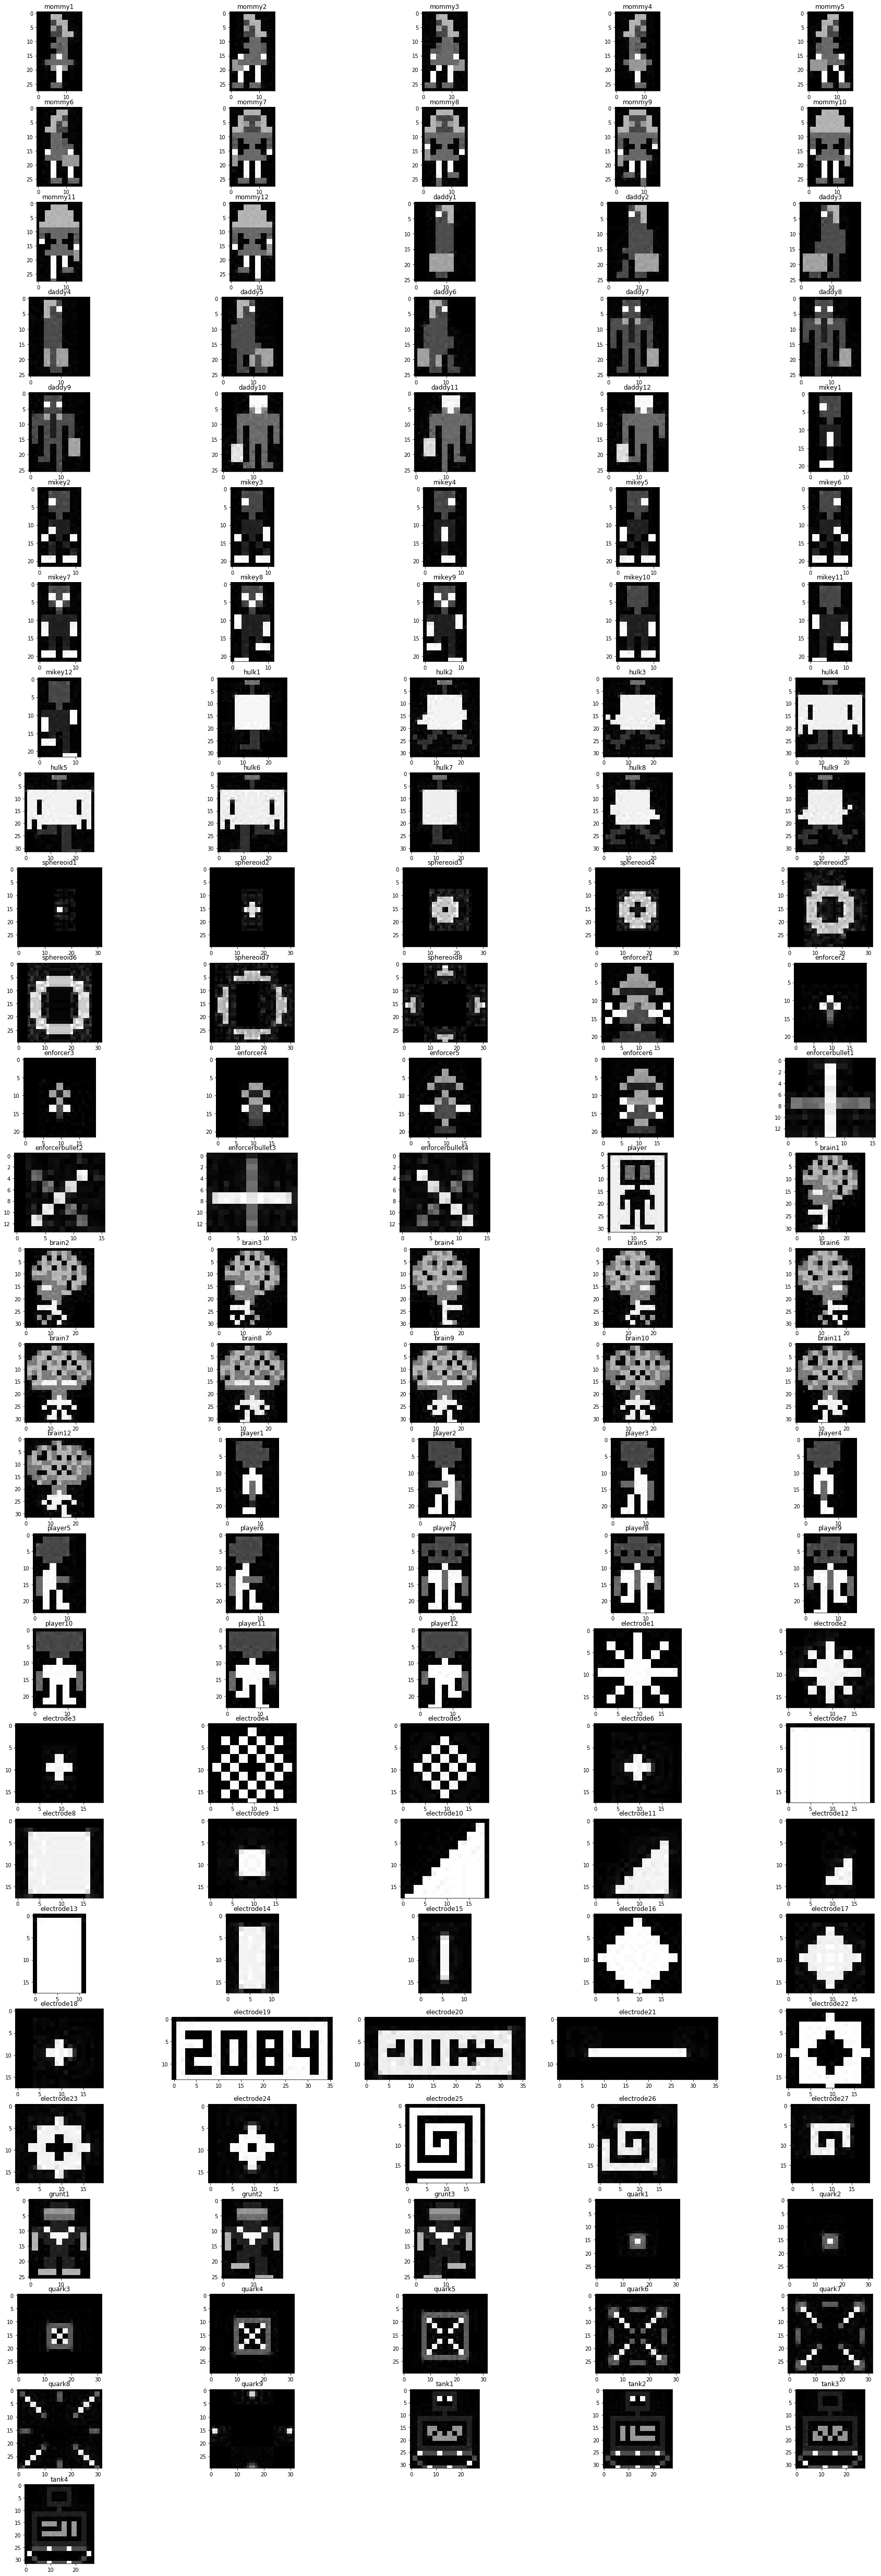

In [2]:
fig=pyplot.figure(figsize=(32, 90))
i = 0
r = 5
c = int(len(X_test) / r) + 1
for img, name in zip(X_test, X_name):
    i += 1
    subplot = fig.add_subplot(c, r, i)
    pyplot.imshow(img, cmap="gray")
    subplot.set_title(name)


In [3]:
from skimage.feature import local_binary_pattern
from skimage.segmentation import active_contour
# To calculate a normalized histogram 
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize
import numpy as np
from moviepy.editor import VideoFileClip

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


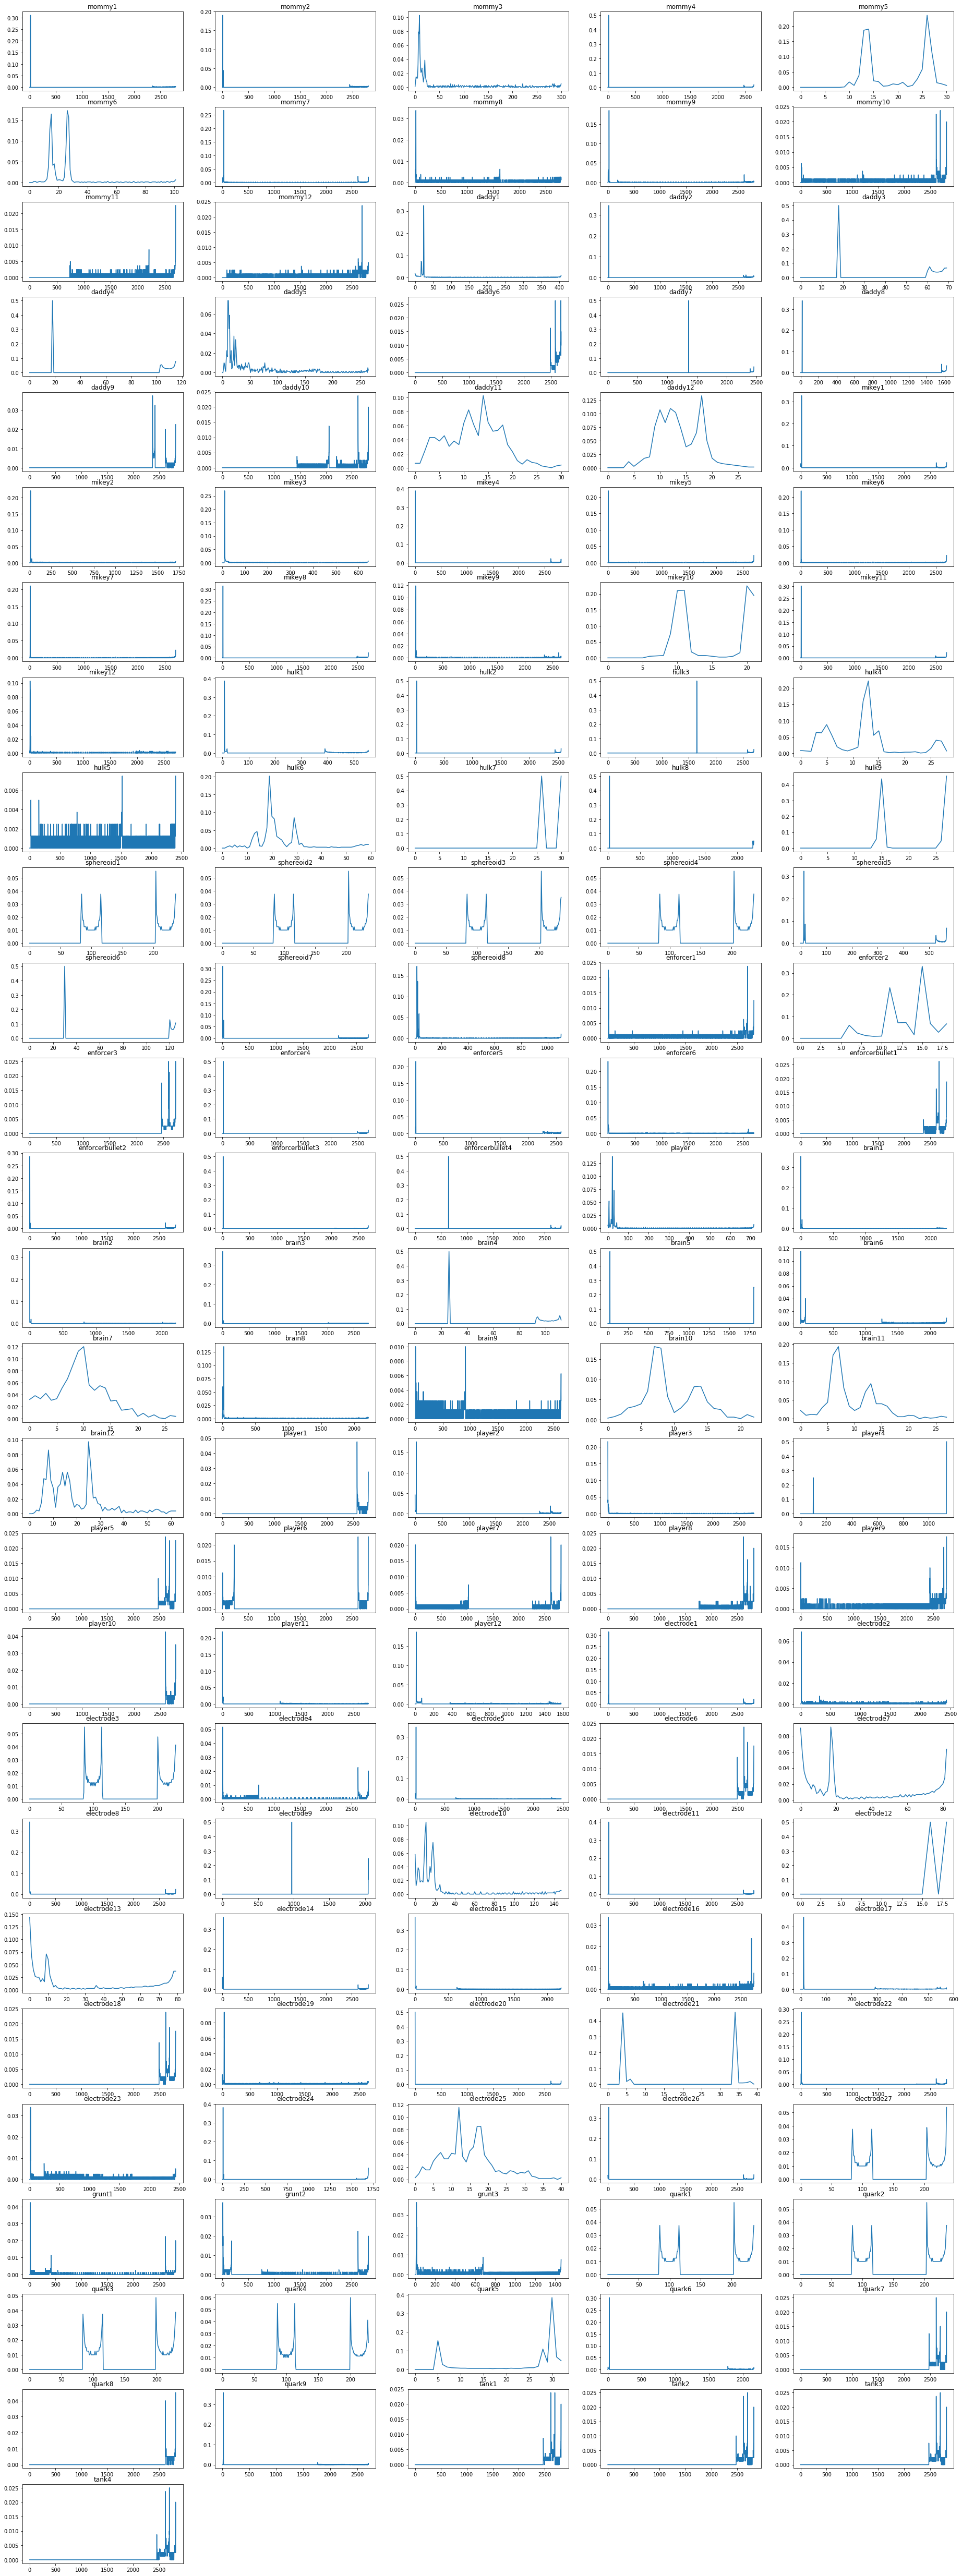

In [4]:
s = np.linspace(0, 2*np.pi, 400)
x = 220 + 100*np.cos(s)
y = 100 + 100*np.sin(s)
init = np.array([x, y]).T

fig=pyplot.figure(figsize=(32, 90))
i = 0
r = 5
c = int(len(X_test) / r) + 1
for img, name in zip(X_test, X_name):
    i += 1
#         snake = active_contour(gaussian(img, 3), init, alpha=0.015, beta=10, gamma=0.001)
    snake = active_contour(img, init, alpha=0.015, beta=10, gamma=0.001)
    n_bins = int(snake.max() + 1)
    hist, _ = np.histogram(snake, density=True, bins=n_bins, range=(0, n_bins))
    subplot = fig.add_subplot(c, r, i)
    pyplot.plot(hist)

    subplot.set_title(name)

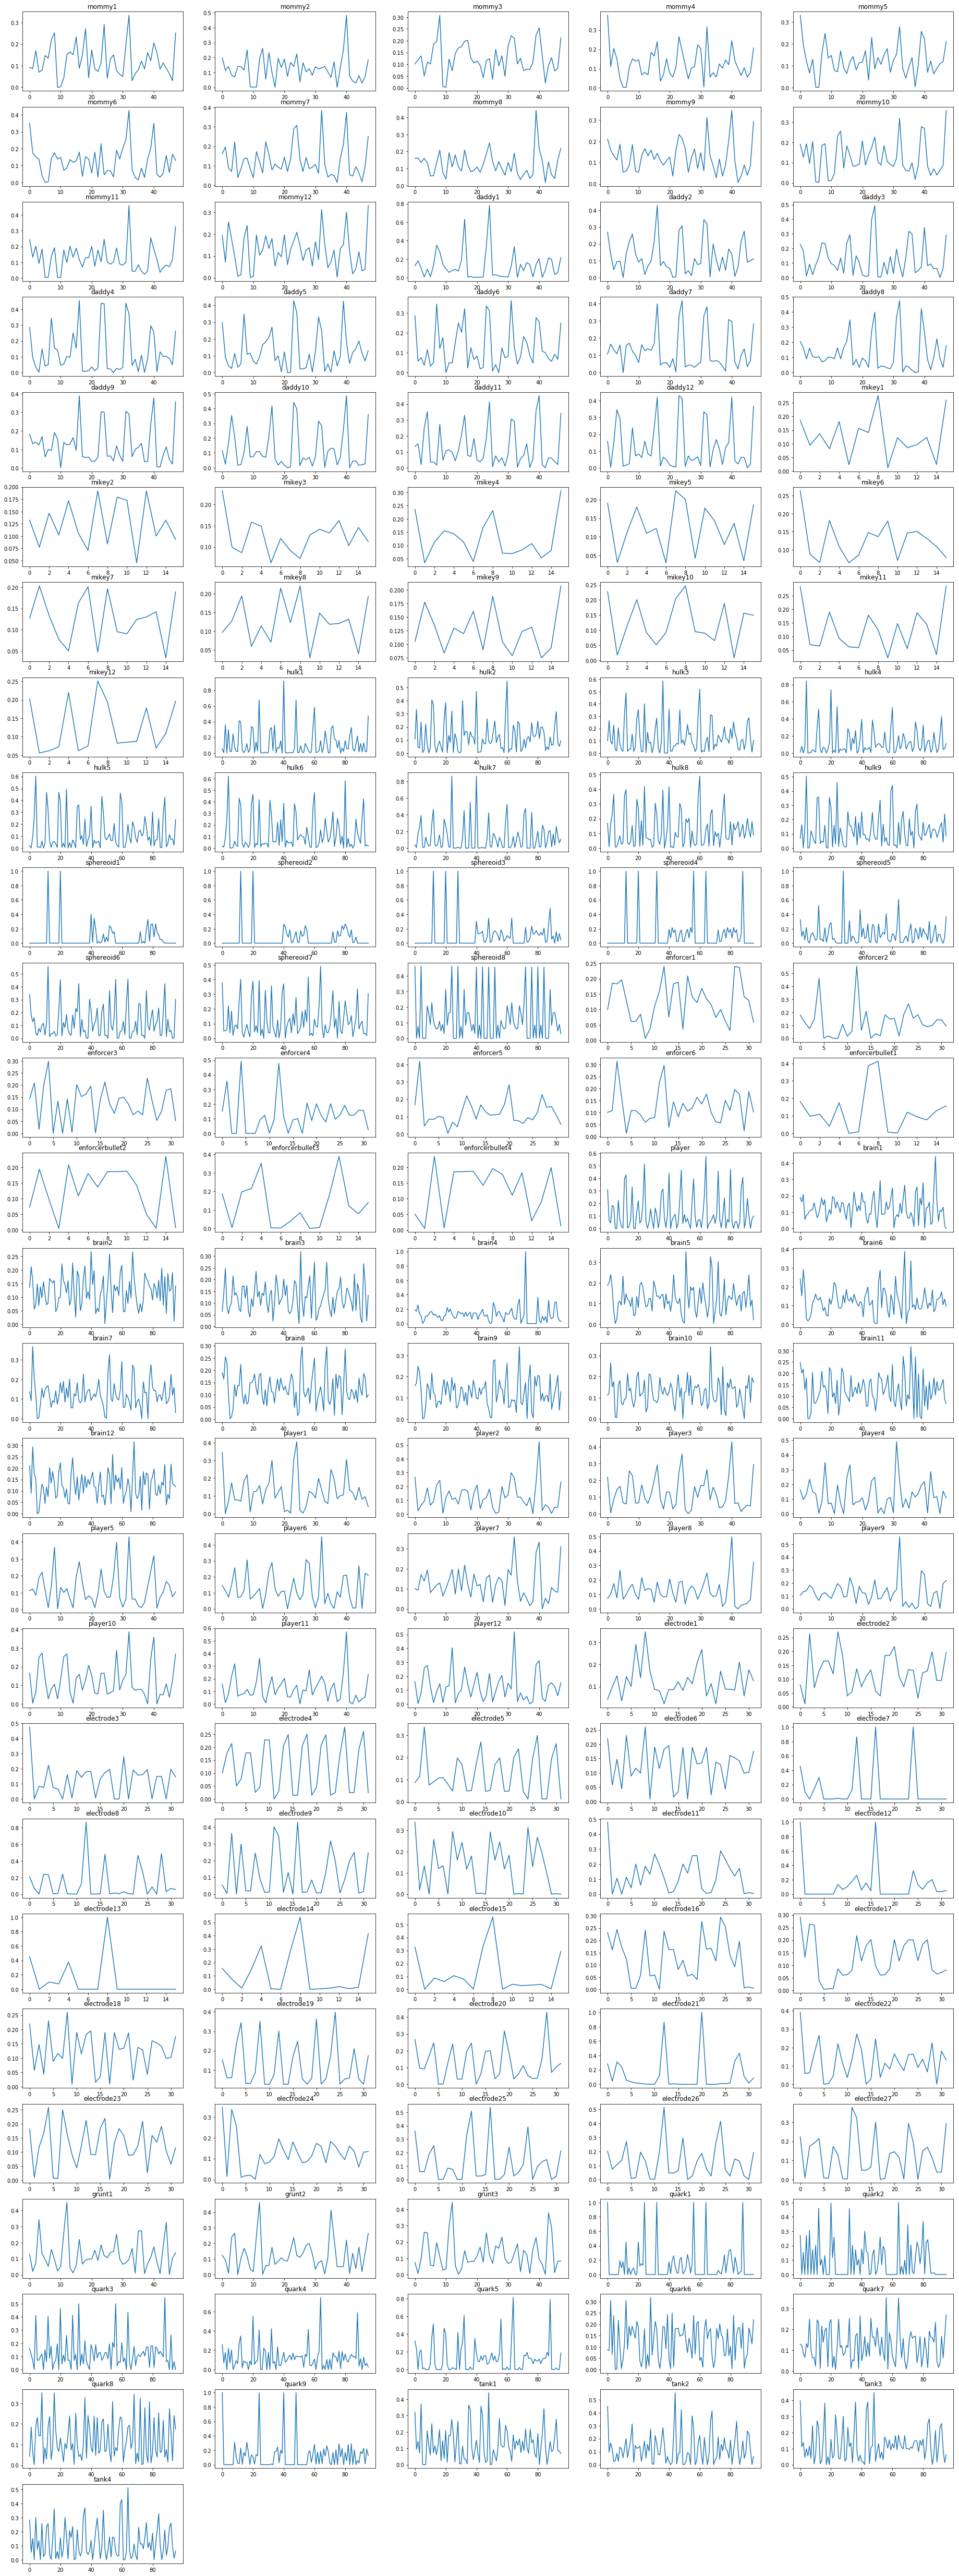

In [5]:
from skimage.feature import hog
fig=pyplot.figure(figsize=(32, 90))
i = 0
r = 5
c = int(len(X_test) / r) + 1
for img, name in zip(X_test, X_name):
    i += 1
    fd = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1))
    subplot = fig.add_subplot(c, r, i)
    pyplot.plot(fd)
    subplot.set_title(name)

In [6]:
def getHist(img):
    img = cv2.resize(img, (32, 32))
    hist = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1))
    return hist

def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

def match(img):
    best_score = 10
    best_name = None
    hist = getHist(img)
    results = []
    for name, ref in zip(X_name, X_test):
        ref_hist = getHist(ref)
        score = kullback_leibler_divergence(hist, ref_hist)
        results.append((name, round(score, 3)))
    results = sorted(results, key=lambda score: score[1])
    return results

In [7]:
def process(frame):
    frame = cv2.resize(frame, (1280, 720))
    crop = frame[115:608, 309:975]
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,10,255,0)
    blur = cv2.GaussianBlur(thresh, (3, 3), 0)
    contours, hierarchy = cv2.findContours(blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    fig=pyplot.figure(figsize=(32, 90))
    i = 0
    r = 10
    c = int(len(sprites) / 10) + 1
    for contour in enumerate(contours):       
        (x,y,w,h) = cv2.boundingRect(contour[1])
        if h < 10 or h > 415 or w < 5 or w > 145:
            continue
        sprite = gray[y:y+h, x:x+w]
        x += 309
        y += 115
        cv2.rectangle(frame, (x,y), (x+w,y+h), (255, 255, 255), 2)
        guess = match(sprite)
        print("{}\n".format(guess))
        i += 1
        subplot = fig.add_subplot(c, r, i)
        pyplot.imshow(sprite, cmap='gray')
        subplot.set_title("{}-{}".format(i, guess[0]))
        
        cv2.putText(frame, "Class: {}".format(guess[0]), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return frame

[('electrode13', -0.297), ('electrode7', 1.526), ('sphereoid4', 3.474), ('quark1', 4.184), ('electrode8', 4.325), ('sphereoid2', 5.432), ('electrode25', 6.066), ('quark3', 6.541), ('quark2', 6.612), ('sphereoid1', 7.017), ('sphereoid3', 7.147), ('electrode3', 8.26), ('electrode27', 9.737), ('electrode12', 10.423), ('electrode20', 10.62), ('quark4', 11.233), ('quark5', 11.605), ('enforcer4', 11.872), ('electrode26', 11.931), ('sphereoid6', 12.631), ('hulk7', 12.774), ('electrode21', 13.201), ('electrode6', 14.133), ('electrode18', 14.133), ('sphereoid7', 14.209), ('mikey1', 14.35), ('sphereoid5', 14.356), ('electrode14', 14.942), ('electrode11', 15.182), ('electrode22', 15.214), ('enforcer2', 15.317), ('electrode9', 15.324), ('player4', 15.599), ('tank4', 15.873), ('electrode19', 15.891), ('enforcer3', 16.425), ('sphereoid8', 16.657), ('hulk1', 16.886), ('player', 17.215), ('player9', 17.831), ('hulk8', 18.595), ('mikey5', 19.08), ('player12', 19.094), ('player1', 19.292), ('grunt1', 19

[('sphereoid4', 1.121), ('sphereoid1', 2.443), ('electrode13', 2.737), ('sphereoid3', 2.925), ('quark3', 2.946), ('quark1', 3.193), ('hulk6', 3.554), ('electrode7', 3.748), ('sphereoid2', 4.225), ('quark2', 4.287), ('enforcer4', 4.892), ('hulk4', 4.925), ('electrode20', 5.357), ('enforcer3', 5.862), ('enforcer2', 6.439), ('electrode25', 6.624), ('sphereoid8', 6.635), ('electrode3', 6.667), ('electrode12', 6.855), ('hulk5', 6.918), ('quark9', 6.998), ('electrode27', 7.461), ('hulk7', 8.289), ('hulk9', 8.303), ('sphereoid5', 9.467), ('electrode19', 9.841), ('hulk8', 9.947), ('mikey5', 10.055), ('daddy2', 10.544), ('electrode11', 10.717), ('hulk3', 10.765), ('electrode9', 10.768), ('hulk2', 10.839), ('electrode6', 10.956), ('electrode18', 10.956), ('quark5', 10.998), ('quark6', 11.119), ('quark4', 11.302), ('mommy5', 11.35), ('player4', 11.372), ('electrode8', 11.505), ('brain11', 11.829), ('enforcerbullet4', 11.83), ('mommy8', 11.942), ('mikey1', 12.006), ('enforcer5', 12.416), ('electro

[('sphereoid4', 0.026), ('quark1', 0.443), ('sphereoid1', 1.263), ('sphereoid3', 1.747), ('quark2', 1.927), ('sphereoid2', 2.109), ('quark9', 4.849), ('quark3', 4.913), ('enforcer3', 5.262), ('electrode21', 6.048), ('enforcer2', 6.273), ('enforcer1', 6.512), ('sphereoid8', 6.639), ('electrode3', 7.524), ('electrode12', 7.539), ('enforcer4', 8.215), ('mikey5', 8.337), ('electrode13', 8.569), ('quark4', 8.75), ('brain11', 8.893), ('electrode6', 9.117), ('electrode18', 9.117), ('mommy2', 9.306), ('electrode9', 9.333), ('mikey1', 9.425), ('enforcer6', 9.625), ('brain7', 9.678), ('brain12', 9.75), ('mommy7', 9.874), ('enforcer5', 9.881), ('player4', 9.89), ('electrode4', 9.904), ('brain3', 10.027), ('mikey6', 10.04), ('mikey2', 10.223), ('mikey3', 10.255), ('brain1', 10.302), ('brain10', 10.347), ('mommy8', 10.353), ('brain2', 10.395), ('electrode25', 10.453), ('brain8', 10.613), ('mikey8', 10.739), ('brain9', 10.758), ('daddy1', 10.853), ('player1', 10.932), ('mikey9', 11.054), ('sphereoid

[('quark1', 0.364), ('sphereoid4', 0.841), ('electrode13', 1.944), ('quark2', 2.66), ('sphereoid1', 3.007), ('mikey10', 3.208), ('sphereoid3', 3.243), ('mikey7', 3.457), ('quark9', 3.665), ('sphereoid2', 3.696), ('mikey5', 3.808), ('sphereoid8', 4.241), ('electrode7', 4.323), ('mikey11', 4.864), ('electrode21', 5.014), ('mikey8', 5.087), ('mikey9', 5.133), ('electrode12', 5.368), ('mikey12', 5.887), ('quark3', 6.005), ('mikey1', 6.982), ('mikey3', 7.232), ('player4', 7.352), ('mikey6', 7.919), ('electrode27', 8.019), ('enforcer2', 8.581), ('electrode9', 8.592), ('electrode3', 9.538), ('mikey2', 9.694), ('grunt3', 9.707), ('enforcer3', 9.772), ('mommy9', 9.85), ('player10', 9.89), ('enforcer4', 9.978), ('grunt1', 10.006), ('player1', 10.032), ('tank4', 10.06), ('player7', 10.18), ('player9', 10.303), ('player8', 10.344), ('quark4', 10.37), ('player12', 10.401), ('grunt2', 10.509), ('sphereoid5', 10.541), ('sphereoid7', 10.603), ('player11', 10.744), ('electrode4', 10.999), ('mommy7', 11

[('electrode13', 1.727), ('electrode7', 5.259), ('sphereoid4', 6.003), ('sphereoid2', 6.605), ('sphereoid1', 7.528), ('electrode8', 7.786), ('quark1', 7.79), ('sphereoid3', 11.096), ('quark2', 11.47), ('electrode3', 11.73), ('electrode25', 13.303), ('quark3', 13.534), ('quark4', 13.852), ('electrode12', 15.618), ('enforcer4', 16.196), ('hulk7', 16.582), ('sphereoid5', 16.713), ('sphereoid7', 16.928), ('electrode27', 17.013), ('sphereoid6', 17.33), ('electrode11', 17.524), ('hulk1', 17.807), ('sphereoid8', 17.905), ('quark9', 18.616), ('electrode26', 18.629), ('quark5', 18.681), ('electrode14', 18.711), ('enforcer3', 19.045), ('electrode9', 19.419), ('electrode6', 19.573), ('electrode18', 19.573), ('player4', 19.959), ('electrode20', 20.099), ('mikey1', 20.122), ('enforcer2', 20.833), ('tank4', 20.902), ('daddy4', 21.084), ('electrode19', 21.287), ('daddy6', 21.972), ('electrode21', 22.264), ('daddy3', 22.49), ('electrode22', 22.729), ('daddy8', 22.777), ('daddy1', 22.801), ('enforcerbu

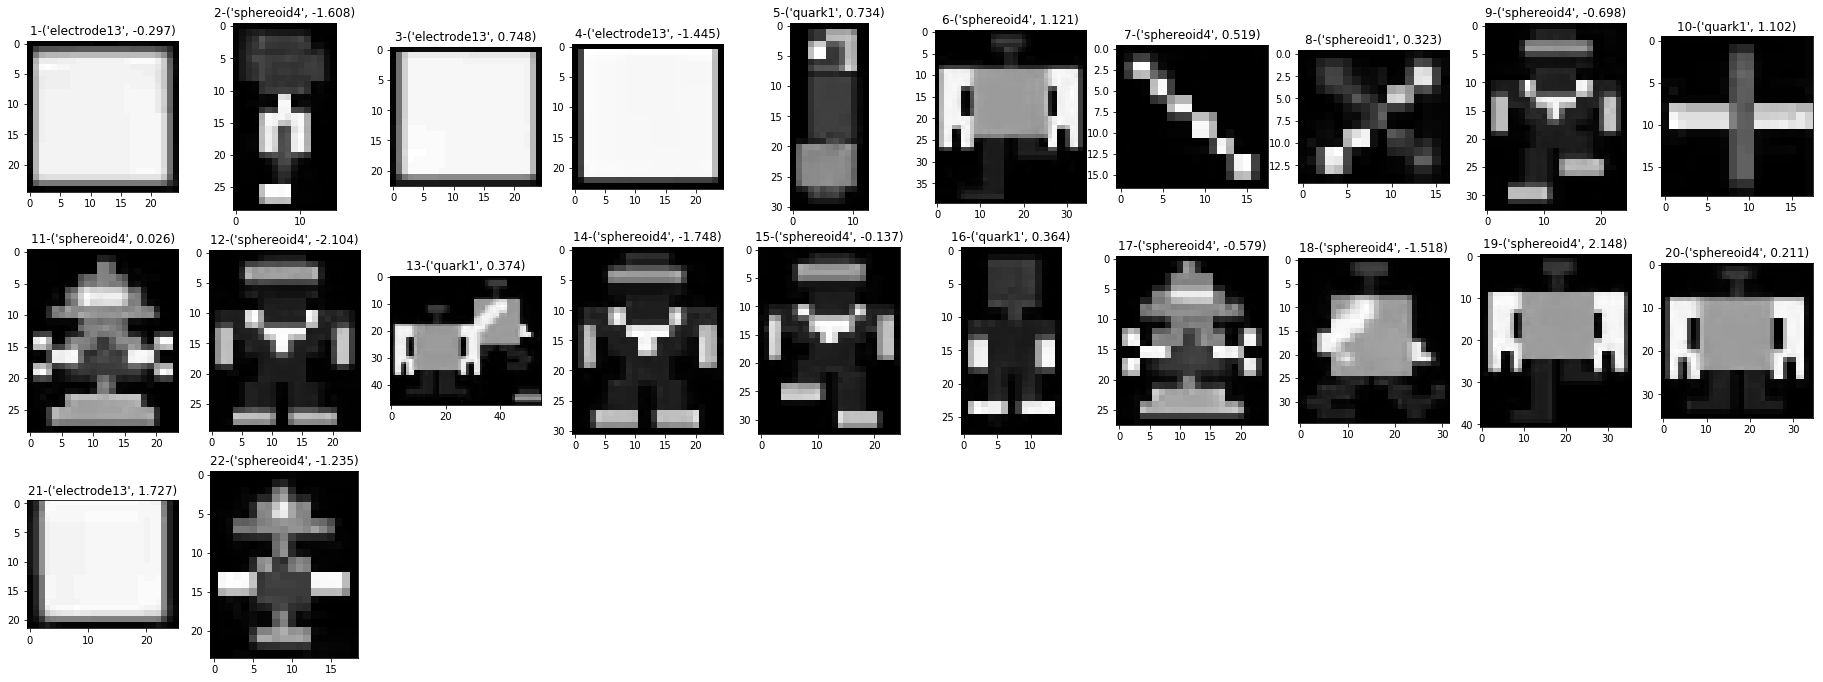

In [8]:
clip = VideoFileClip('/home/strider/Code/robotron/resources/video/robotron-1.mp4')
img = clip.get_frame(101.6)
pyplot.rcParams['figure.figsize'] = [24, 16]
im = process(img)

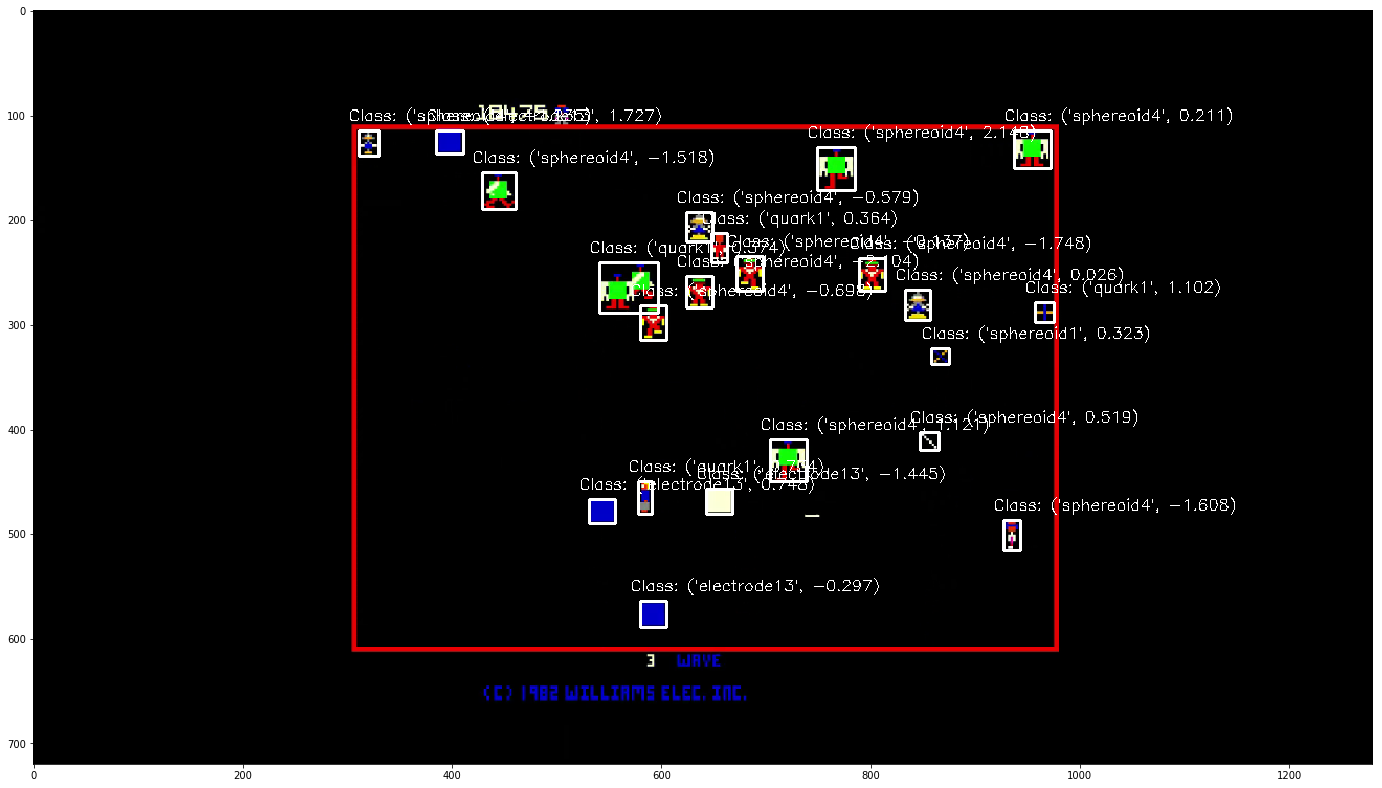

In [9]:
pyplot.imshow(im)